Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re
import string
import nltk
import contractions
import tensorflow as tf


from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.layers import Input
from keras.models import Model


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report, roc_auc_score, multilabel_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


from wordcloud import WordCloud
from collections import Counter
from PIL import Image, ImageFilter

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aquat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aquat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aquat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aquat\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Importing all the datasets

In [3]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')
val = pd.read_csv('dataset/validation.csv')


In [4]:
train.head()

,id,feedback_text,toxic,abusive,vulgar,menace,offense,bigotry
0,281d77b7bebc2201,:::Sounds good. Let me know when you're done ...,0,0,0,0,0,0
1,716aac7bf3c63db1,"""\nI say something, but it didn't actually con...",0,0,0,0,0,0
2,57cb318c6edcf10c,"""Agustina Barrientos]] \n | Modelo de Piñeiro ...",0,0,0,0,0,0
3,dc3bd70118d91b3a,FYI I enjoy licking strangers scrotal sacks......,1,0,1,0,0,0
4,cf10d41f2997d233,How do you get a site?\nMany penguins have ask...,0,0,0,0,0,0


In [5]:
test.head()

,id,content,lang
0,56496,"Bahar merhaba, Şu TV programı için bildiğin gi...",tr
1,18266,"Merhaba, başlık taşıma nedeniyle bir karışıklı...",tr
2,37852,kullanıcı ne mutlu türküm diyene yazmış ta...,tr
3,25075,Quand la plaisanterie sur le synopsis de ce fi...,fr
4,330,Não fosse seu esclarecimento no blog da Anne (...,pt


In [6]:

val.head()

,id,feedback_text,lang,toxic
0,1203,İyi tamam olabilir. Balkanlar maddesini gelişt...,tr,0
1,5871,"Por dios, y la canción de John Lennon: http://...",es,1
2,3590,Selam. Öncelikle tebrik ederim... Bu arada ken...,tr,0
3,447,Leggiti tutte le discussioni. Magari cancellal...,it,1
4,6634,A LAS TOKITAS NOS VALE QUE LAS JONATICAS INSUL...,es,1


In [7]:
#check the shape of the dataset
print(f"Train shape: {train.shape}")
print(f"\nTest shape: {test.shape}")
print(f"\nValidation shape: {val.shape}")

# Check the data types of the columns
print("\nData types:")
print(train.dtypes)
print("\nTest data types:")
print(test.dtypes)
print("\nValidation data types:")
print(val.dtypes)

Train shape: (23473, 8)

Test shape: (6700, 3)

Validation shape: (840, 4)

Data types:
id               object
feedback_text    object
toxic             int64
abusive           int64
vulgar            int64
menace            int64
offense           int64
bigotry           int64
dtype: object

Test data types:
id          int64
content    object
lang       object
dtype: object

Validation data types:
id                int64
feedback_text    object
lang             object
toxic             int64
dtype: object


Data cleaning

In [8]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = contractions.fix(text)                    # Expand contractions
    text = text.lower()                              # Lowercase
    text = re.sub(r'\d+', '', text)                  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)              # Remove punctuation
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

train['clean_text'] = train['feedback_text'].apply(clean_text)


In [9]:
train.head()

,id,feedback_text,toxic,abusive,vulgar,menace,offense,bigotry,clean_text
0,281d77b7bebc2201,:::Sounds good. Let me know when you're done ...,0,0,0,0,0,0,sound good let know done start pr
1,716aac7bf3c63db1,"""\nI say something, but it didn't actually con...",0,0,0,0,0,0,say something actually confirm anything put ar...
2,57cb318c6edcf10c,"""Agustina Barrientos]] \n | Modelo de Piñeiro ...",0,0,0,0,0,0,agustina barrientos modelo de piñeiro juán cru...
3,dc3bd70118d91b3a,FYI I enjoy licking strangers scrotal sacks......,1,0,1,0,0,0,fyi enjoy licking stranger scrotal sacksespeci...
4,cf10d41f2997d233,How do you get a site?\nMany penguins have ask...,0,0,0,0,0,0,get site many penguin asked question simple go...


In [10]:
# Check for missing and null values
missing_data = train.isnull().sum()
null_data = train.isnull().sum()

print("Missing data:")
print(missing_data)

print("\nNull data:")
print(null_data)

duplicates = train.duplicated().sum()
print(f"Number of duplicates: {duplicates}")

# Check for unique values in categorical columns
categorical_columns = train.select_dtypes(include=['object']).columns  
for column in categorical_columns:
    unique_values = train[column].nunique()
    print(f"Unique values in {column}: {unique_values}")

Missing data:
id               0
feedback_text    0
toxic            0
abusive          0
vulgar           0
menace           0
offense          0
bigotry          0
clean_text       0
dtype: int64

Null data:
id               0
feedback_text    0
toxic            0
abusive          0
vulgar           0
menace           0
offense          0
bigotry          0
clean_text       0
dtype: int64
Number of duplicates: 0
Unique values in id: 23473
Unique values in feedback_text: 23473
Unique values in clean_text: 23395


In [11]:
# Checking for long comments
train['text_length'] = train['feedback_text'].apply(len)
train['word_count'] = train['feedback_text'].apply(lambda x: len(str(x).split()))

long_comments = train[train['word_count'] > 400] # Filter comments longer than 400 words
print(f"Number of long comments (> 400 words): {len(long_comments)}")

Number of long comments (> 400 words): 488


In [12]:
# Check the distribution of labels in long comments
label_cols = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']

# Count how many labels are active (1) in each long comment
long_comments['num_labels'] = long_comments[label_cols].sum(axis=1)

# Distribution of how many offensive types per long comment
print(long_comments['num_labels'].value_counts())
print("\nPercentage breakdown:")
print((long_comments['num_labels'].value_counts(normalize=True) * 100).round(2))

num_labels
0    452
1     10
4     10
3      8
2      6
5      2
Name: count, dtype: int64

Percentage breakdown:
num_labels
0    92.62
1     2.05
4     2.05
3     1.64
2     1.23
5     0.41
Name: proportion, dtype: float64


C:\Users\aquat\AppData\Local\Temp\ipykernel_10404\1427695070.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_comments['num_labels'] = long_comments[label_cols].sum(axis=1)


In [13]:
# Filter out long neutral comments
train_df = train[~((train['word_count'] > 400) & (train[label_cols].sum(axis=1) == 0))]

In [14]:
train_df.shape

(23021, 11)

Exploratory Data Analysis

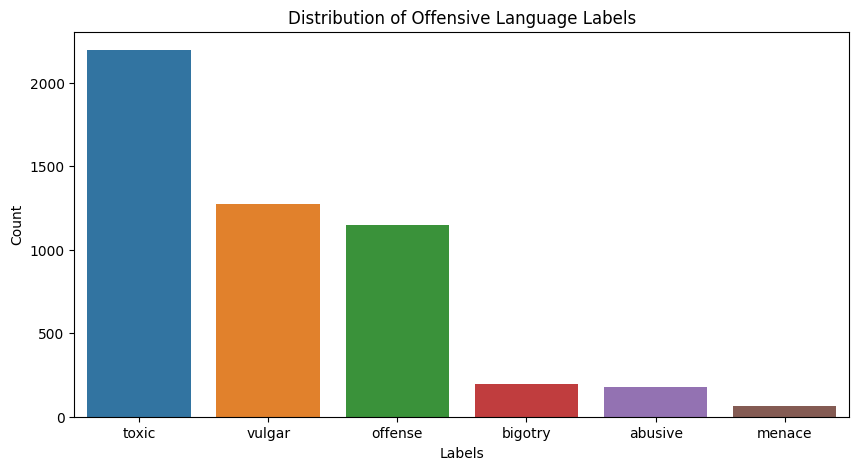

In [15]:
# Checking the distribution of the target variable

label_cols = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']
label_counts = train[label_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Offensive Language Labels')
plt.ylabel('Count')
plt.xlabel('Labels')
plt.show()


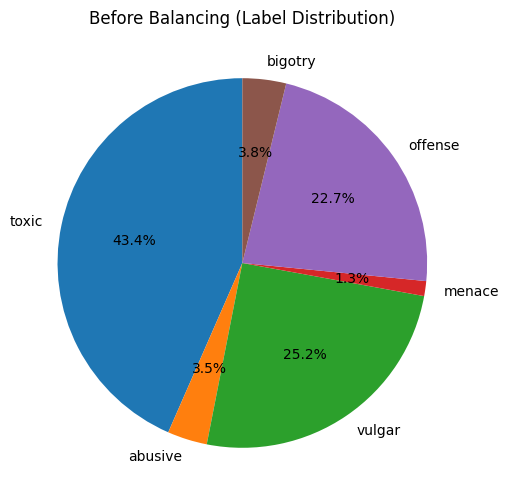

In [16]:
#Balancing the Dataset
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

train_df = pd.read_csv('dataset/train.csv')

original_counts = train[label_cols].sum()

plt.figure(figsize=(6, 6))
plt.pie(original_counts, labels=label_cols, autopct='%1.1f%%', startangle=90)
plt.title("Before Balancing (Label Distribution)")
plt.show()

In [17]:
max_count = original_counts.max()
balanced_train = pd.DataFrame()

for label in label_cols:
    positives = train[train[label] == 1]
    oversampled = resample(
        positives,
        replace=True,
        n_samples=max_count,
        random_state=42
    )
    balanced_train = pd.concat([balanced_train, oversampled])
    
balanced_train = balanced_train.sample(frac=1, random_state=42).reset_index(drop=True)

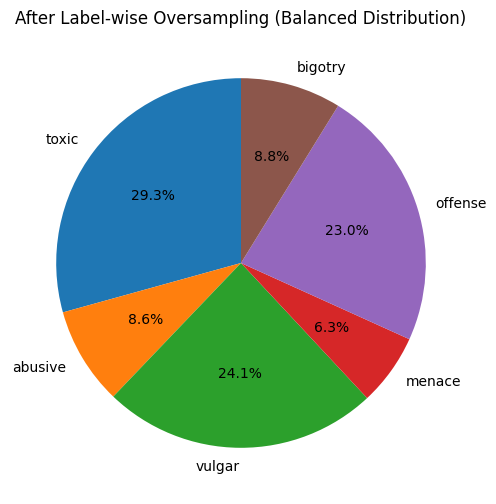

In [18]:
balanced_counts = balanced_train[label_cols].sum()

plt.figure(figsize=(6, 6))
plt.pie(balanced_counts, labels=label_cols, autopct='%1.1f%%', startangle=90)
plt.title("After Label-wise Oversampling (Balanced Distribution)")
plt.show()

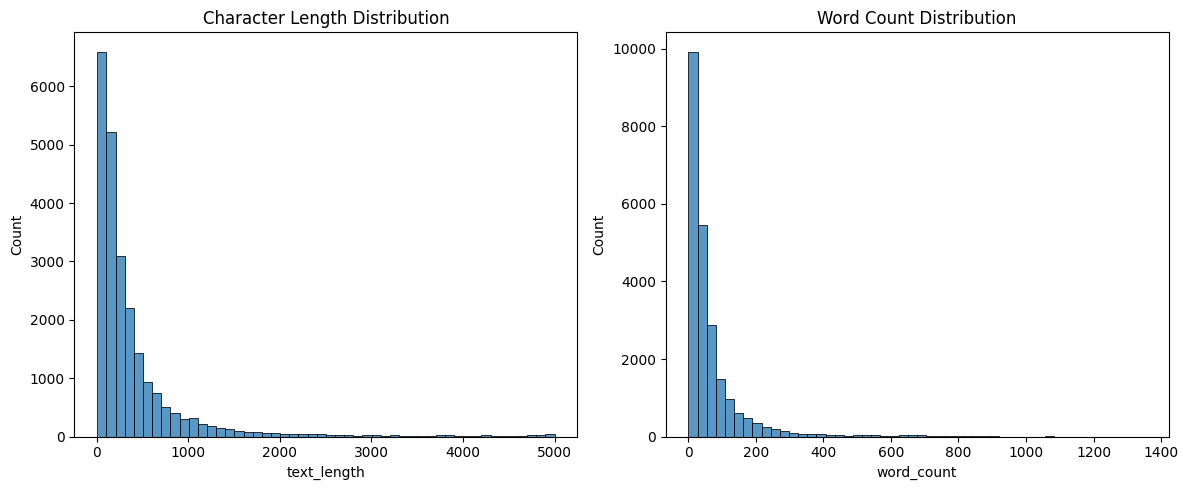

In [19]:
# Analyzing feedback length analysis
train['text_length'] = train['feedback_text'].apply(len)
train['word_count'] = train['feedback_text'].apply(lambda x: len(str(x).split()))

# Plot histograms
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(train['text_length'], bins=50, ax=ax[0])
ax[0].set_title('Character Length Distribution')

sns.histplot(train['word_count'], bins=50, ax=ax[1])
ax[1].set_title('Word Count Distribution')

plt.tight_layout()
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aquat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


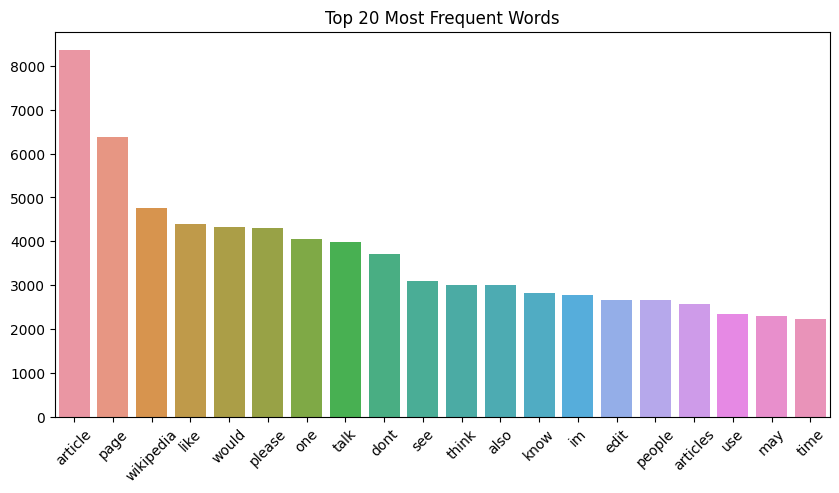

In [20]:
# Finding most frequent words

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    tokens = str(text).lower().translate(str.maketrans('', '', string.punctuation)).split()
    return [t for t in tokens if t not in stop_words]

all_words = []
train['feedback_text'].apply(lambda x: all_words.extend(clean_text(x)))
word_freq = Counter(all_words)

# Top 20 words
common_words = word_freq.most_common(20)

plt.figure(figsize=(10, 5))
sns.barplot(x=[w[0] for w in common_words], y=[w[1] for w in common_words])
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Words")
plt.show()


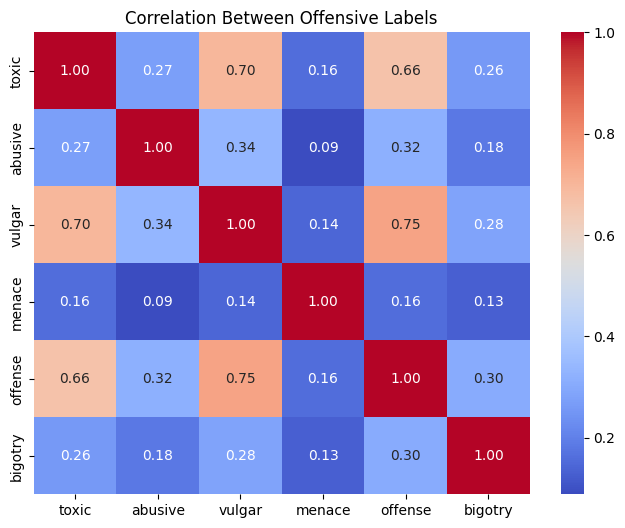

In [21]:
# Correlation Heatmap to find how often certain offensive labels occur together 
plt.figure(figsize=(8, 6))
sns.heatmap(train[label_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Offensive Labels")
plt.show()

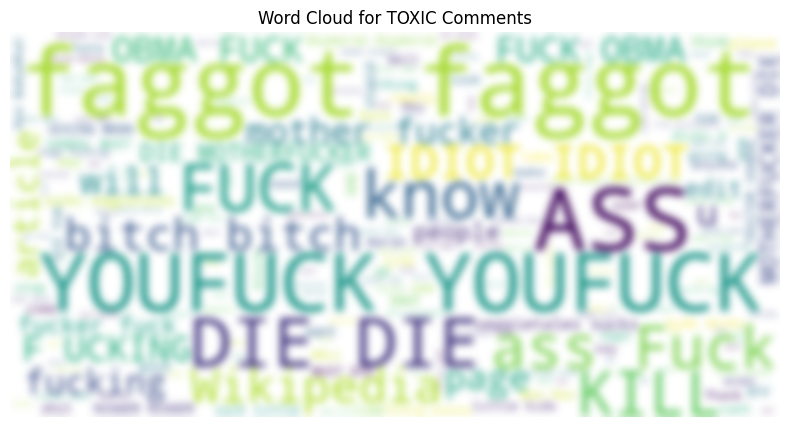

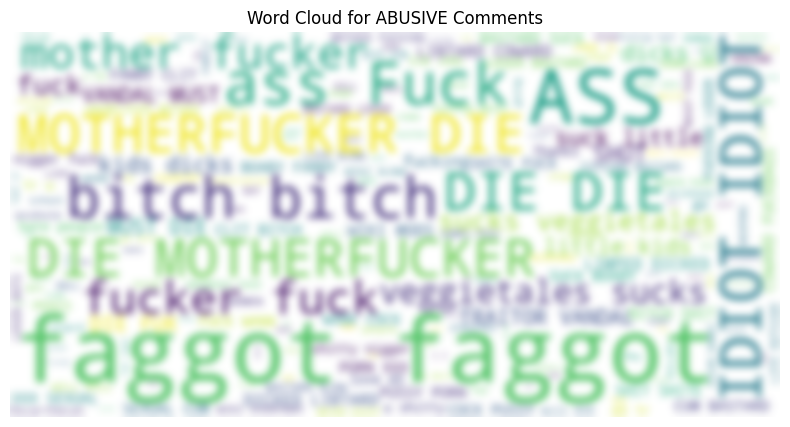

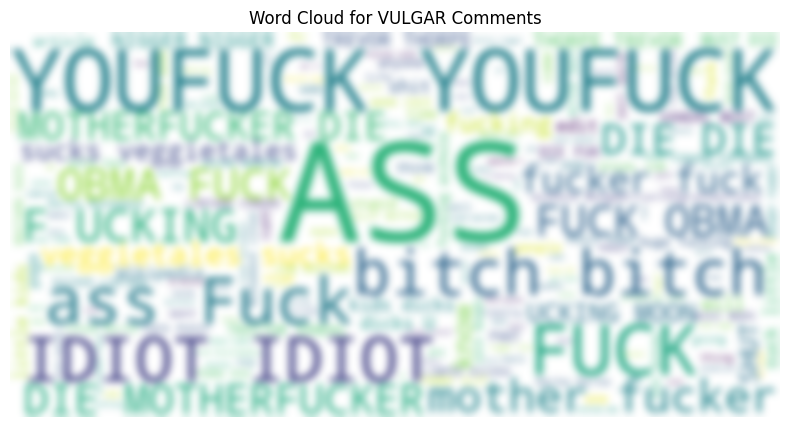

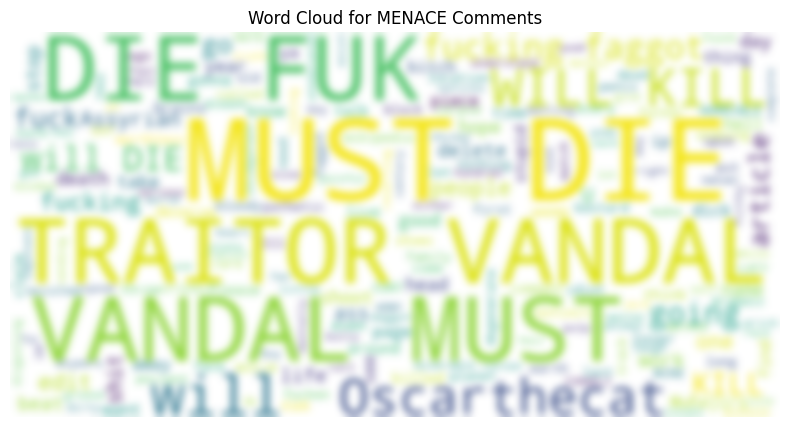

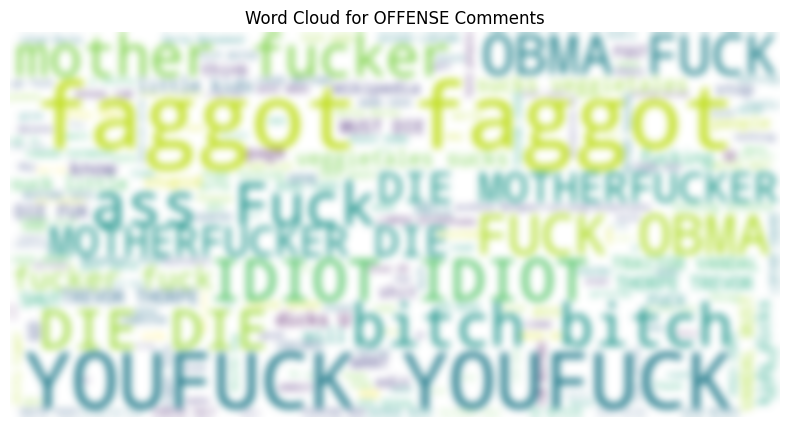

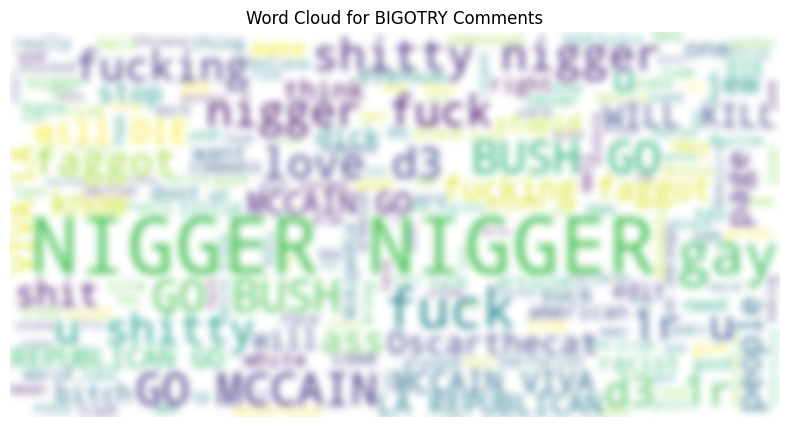

In [22]:
for label in label_cols:
    text = " ".join(train[train[label] == 1]['feedback_text'].astype(str))
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Convert to PIL Image and apply blur
    img = wc.to_image()
    blurred_img = img.filter(ImageFilter.GaussianBlur(radius=4))  # adjust radius as needed

    # Show blurred image
    plt.figure(figsize=(10, 5))
    plt.imshow(blurred_img)
    plt.axis('off')
    plt.title(f"Word Cloud for {label.upper()} Comments")
    plt.show()


Tokenization

In [23]:
MAX_NUM_WORDS = 20000
tokenizer= Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train['clean_text'])


In [24]:
word_vector = tokenizer.texts_to_sequences(train['clean_text'])

In [25]:
word_index = tokenizer.word_index

In [26]:
vocab_size = len(word_index)
vocab_size   # num of unique tokens

66513

In [27]:
MAX_SEQ_LENGTH = 250
input_tensor = pad_sequences(word_vector, maxlen=MAX_SEQ_LENGTH)

In [28]:
input_tensor.shape

(23473, 250)

## Model Training

### BERT

In [29]:
# Preparing the labels
X = train_df['feedback_text']
y = train_df[['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']]

X_train_text, X_val_text, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# Load pretrained BERT
from transformers import BertTokenizer, TFBertModel

bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize
def tokenize_texts(texts, tokenizer, max_len=128):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        return_tensors='tf',
        max_length=max_len
    )

train_encodings = tokenize_texts(X_train_text, bert_tokenizer)
val_encodings = tokenize_texts(X_val_text, bert_tokenizer)

# Build model
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(128,), dtype=tf.int32, name='attention_mask')

bert_output = bert_model(input_ids, attention_mask=attention_mask)[1]
output = Dense(6, activation='sigmoid')(bert_output)

bert_classifier = Model(inputs=[input_ids, attention_mask], outputs=output)

bert_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train
bert_classifier.fit(
    x={
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask']
    },
    y=y_train,
    validation_data=(
        {
            'input_ids': val_encodings['input_ids'],
            'attention_mask': val_encodings['attention_mask']
        },
        y_val
    ),
    epochs=3,
    batch_size=16
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/3
1174/1174 [==============================] - 10779s 9s/step - loss: 0.0653 - accuracy: 0.8331 - val_loss: 0.0497 - val_accuracy: 0.4852
Epoch 2/3
1174/1174 [==============================] - 9309s 8s/step - loss: 0.0401 - accuracy: 0.7172 - val_loss: 0.0474 - val_accuracy: 0.4390
Epoch 3/3
1010/1174 [========================>.....] - ETA: 20:07 - loss: 0.0277 - accuracy: 0.6379